In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely.geometry
import seaborn as sns
import plotly.express as px
import re
from matplotlib.colors import TwoSlopeNorm
import missingno as msno
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import math

In [2]:
import plotly.io as pio
pio.renderers.default = 'notebook_connected'
pd.set_option('display.max_columns', None)

In [3]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 200

In [4]:
# Projected Coordinate System: how you project onto a 2D plane
epsg_2d = 26717 
# Toronto Police Service Open Data includes geographic location information provided in
# the projected coordinate system NAD 1927 UTM 17N
# https://epsg.io/26717

# Geographic Coordinate System: how coordinates are represented in a 3D space
# World Geodetic System 1984 (WGS84)
# https://epsg.io/4326
epsg_3d = 4326 

In [5]:
stations_point = gpd.read_file('../data/processed/stations_point.geojson')
stations_area = gpd.read_file('../data/processed/stations_area.geojson')

# Import traffic collisions

In [6]:
# geojson format is too big -> use csv instead
collision_point = pd.read_csv('../data/processed/collision_select.csv')
collision_point['geometry'] = collision_point.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)
collision_point = gpd.GeoDataFrame(collision_point, crs='epsg:' + str(epsg_3d), geometry='geometry')

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [7]:
collision_point

occurrence_unique_id      occurrence_date occurrence_month  \
0            GO-20141283080  2014-01-04 22:00:00          January   
1            GO-20141384134  2014-01-21 12:00:00          January   
2            GO-20141283152  2014-01-04 22:00:00          January   
3            GO-20141384194  2014-01-21 12:00:00          January   
4            GO-20141283293  2014-01-04 22:00:00          January   
...                     ...                  ...              ...   
452740         GO-202240093  2021-12-15 12:00:00         December   
452741         GO-202241692  2021-12-24 01:00:00         December   
452742       GO-20228035384  2021-12-31 16:00:00         December   
452743       GO-20228035412  2021-12-30 14:00:00         December   
452744       GO-20228035413  2021-12-31 19:00:00         December   

       occurrence_dayofweek  occurrence_year  occurrence_hour hood_id  \
0                  Saturday             2014               22      58   
1                   Tuesday             2014               12      11   
2                  Saturday             2014               22     130   
3                   Tuesday             2014               12      27   
4                  Saturday             2014               22     130   
...                     ...              ...              ...     ...   
452740            Wednesday             2021               12      26   
452741               Friday             2021                1      21   
452742               Friday             2021               16      36   
452743             Thursday             2021               14       1   
452744               Friday             2021               19      93   

                              neighbourhood  fatalities  injury_collisions  \
0                             Old East York           0                  0   
1            Eringate-Centennial-West Deane           0                  0   
2                                  Milliken           0                  0   
3                   York University Heights           0                  1   
4                                  Milliken           0                  0   
...                                     ...         ...                ...   
452740                 Downsview-Roding-CFB           0                  0   
452741                        Humber Summit           0                  0   
452742                     Newtonbrook West           0                  1   
452743               West Humber-Clairville           0                  0   
452744  Dovercourt-Wallace Emerson-Junction           0                  0   

        ftr_collisions  pd_collisions  longitude   latitude  occurrence_day  \
0                    1              0 -79.336333  43.697612               4   
1                    0              1 -79.561759  43.664797              21   
2                    1              0 -79.280932  43.828194               4   
3                    0              0 -79.471439  43.767827              21   
4                    0              1 -79.282497  43.822062               4   
...                ...            ...        ...        ...             ...   
452740               0              1 -79.508595  43.720916              15   
452741               0              1 -79.543408  43.770921              24   
452742               0              0 -79.420043  43.798000              31   
452743               0              1 -79.601404  43.730470              30   
452744               0              1 -79.423228  43.665622              31   

        occurrence_dayofyear  fatal_collisions  occurrence_quarter  \
0                          4                 0                   1   
1                         21                 0                   1   
2                          4                 0                   1   
3                         21                 0                   1   
4                          4                 0                   

In [8]:
collision_point.columns

Index(['occurrence_unique_id', 'occurrence_date', 'occurrence_month',
       'occurrence_dayofweek', 'occurrence_year', 'occurrence_hour', 'hood_id',
       'neighbourhood', 'fatalities', 'injury_collisions', 'ftr_collisions',
       'pd_collisions', 'longitude', 'latitude', 'occurrence_day',
       'occurrence_dayofyear', 'fatal_collisions', 'occurrence_quarter',
       'geometry'],
      dtype='object')

In [9]:
collision_point.replace({'occurrence_month': {'January': 'Jan',
                                              'February': 'Feb',
                                              'March': 'Mar',
                                              'April': 'Apr',
                                              'May': 'May',
                                              'June': 'Jun',
                                              'July': 'Jul',
                                              'August': 'Aug',
                                              'September': 'Sep',
                                              'October': 'Oct',
                                              'November': 'Nov',
                                              'December': 'Dec'},
                         'occurrence_dayofweek': {'Monday': "Mon",
                                                  'Tuesday': "Tue",
                                                  'Wednesday': "Wed",
                                                  'Thursday': "Thu",
                                                  'Friday': "Fri",
                                                  'Saturday': "Sat",
                                                  'Sunday': "Sun"}}, inplace=True)


# Distribution by time period

Text(0.5, 0.98, 'Number of traffic collisions by time period in Toronto neighbourhoods')

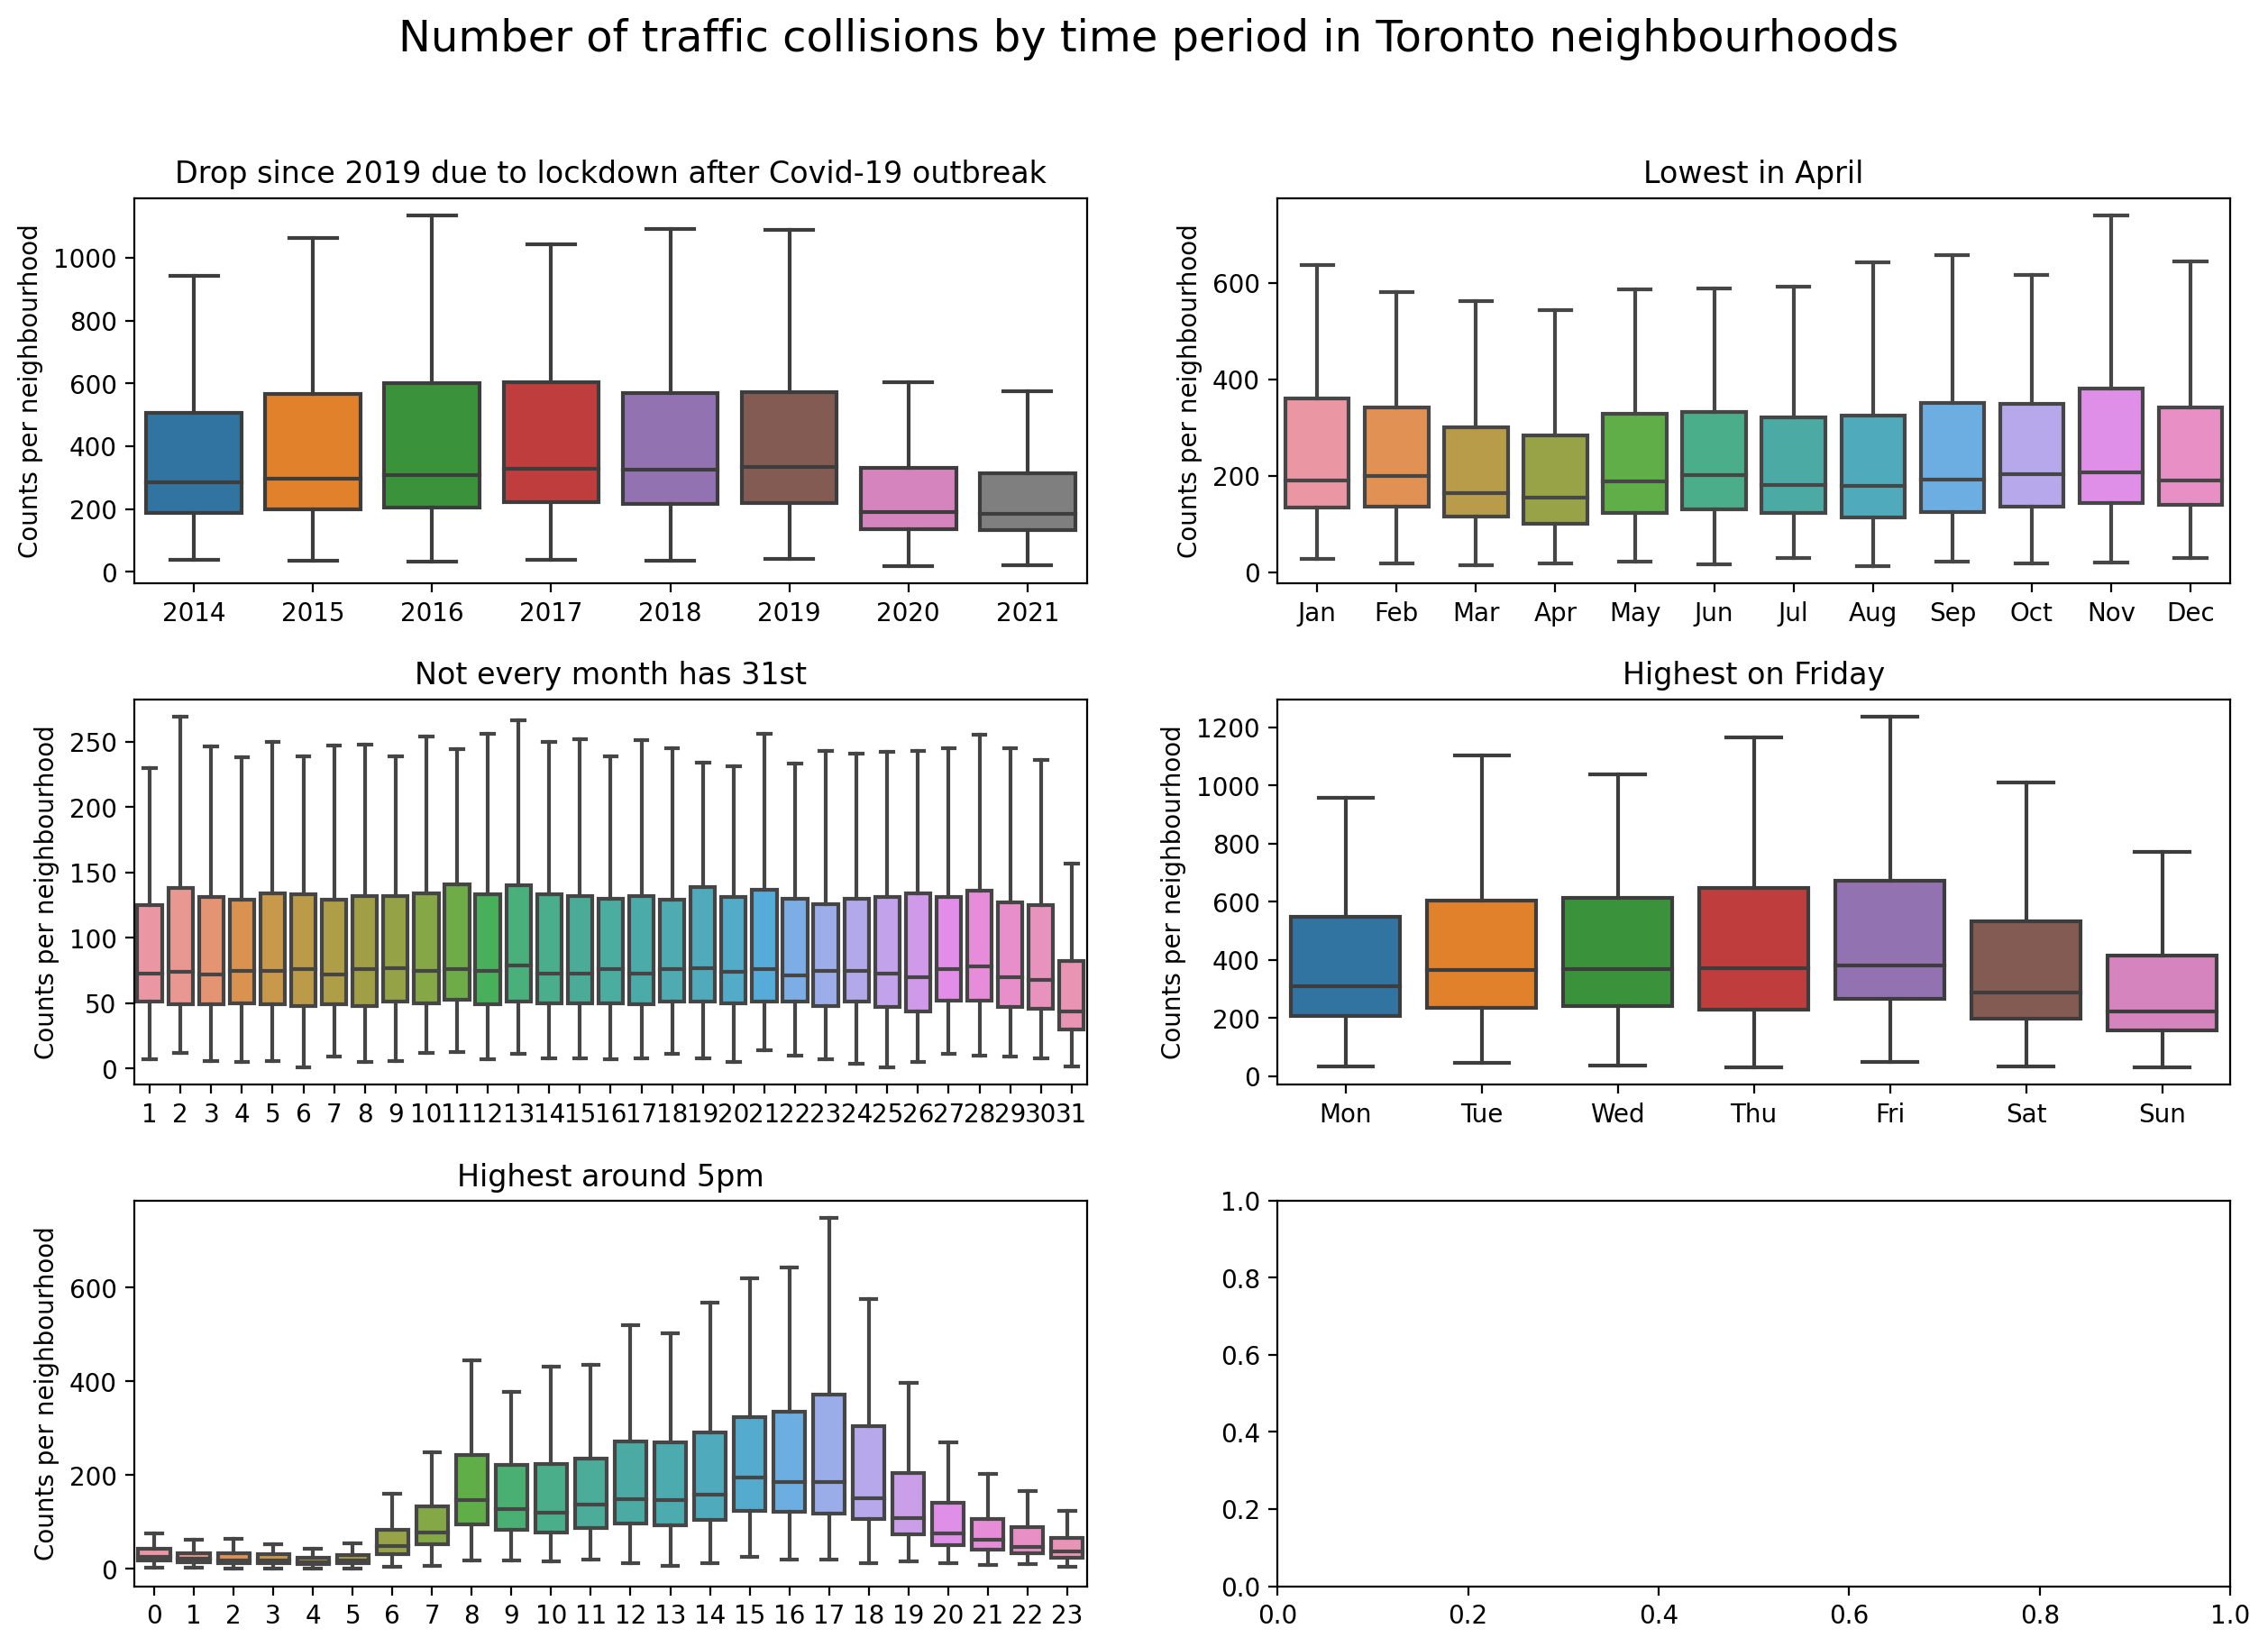

In [12]:
vars = ['occurrence_year', 
        'occurrence_month', 
        'occurrence_day',
        'occurrence_dayofweek',
        'occurrence_hour']
vars_cat = [sorted(collision_point.occurrence_year.unique()),
            ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
            np.arange(1,32,1),
            ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
            np.arange(0,24,1)
            ]
titles = ['Drop since 2019 due to lockdown after Covid-19 outbreak',
         'Lowest in April',
         'Not every month has 31st',
         'Highest on Friday',
         'Highest around 5pm']

fig, axes = plt.subplots(int(math.ceil(len(vars)/2)),2)
plt.subplots_adjust(hspace=0.3)
for var, var_cat, title, ax in zip(vars, vars_cat, titles, axes.flatten()):    
    collision_point[var] = collision_point[var].astype('category').cat.set_categories(var_cat)
    sns.boxplot(data = collision_point.groupby(['neighbourhood', var]).size().reset_index(name='count'), 
                x = var,
                y = 'count',
                showfliers = False,
                ax = ax)
    ax.set_ylabel('Counts per neighbourhood')
    ax.set_xlabel('')
    ax.set_title(title)

fig.suptitle('Number of traffic collisions by time period in Toronto neighbourhoods', size='xx-large')

# Time trend by type of collision

Text(0.5, 0.98, 'Traffic collisions in Toronto neighbourhoods')

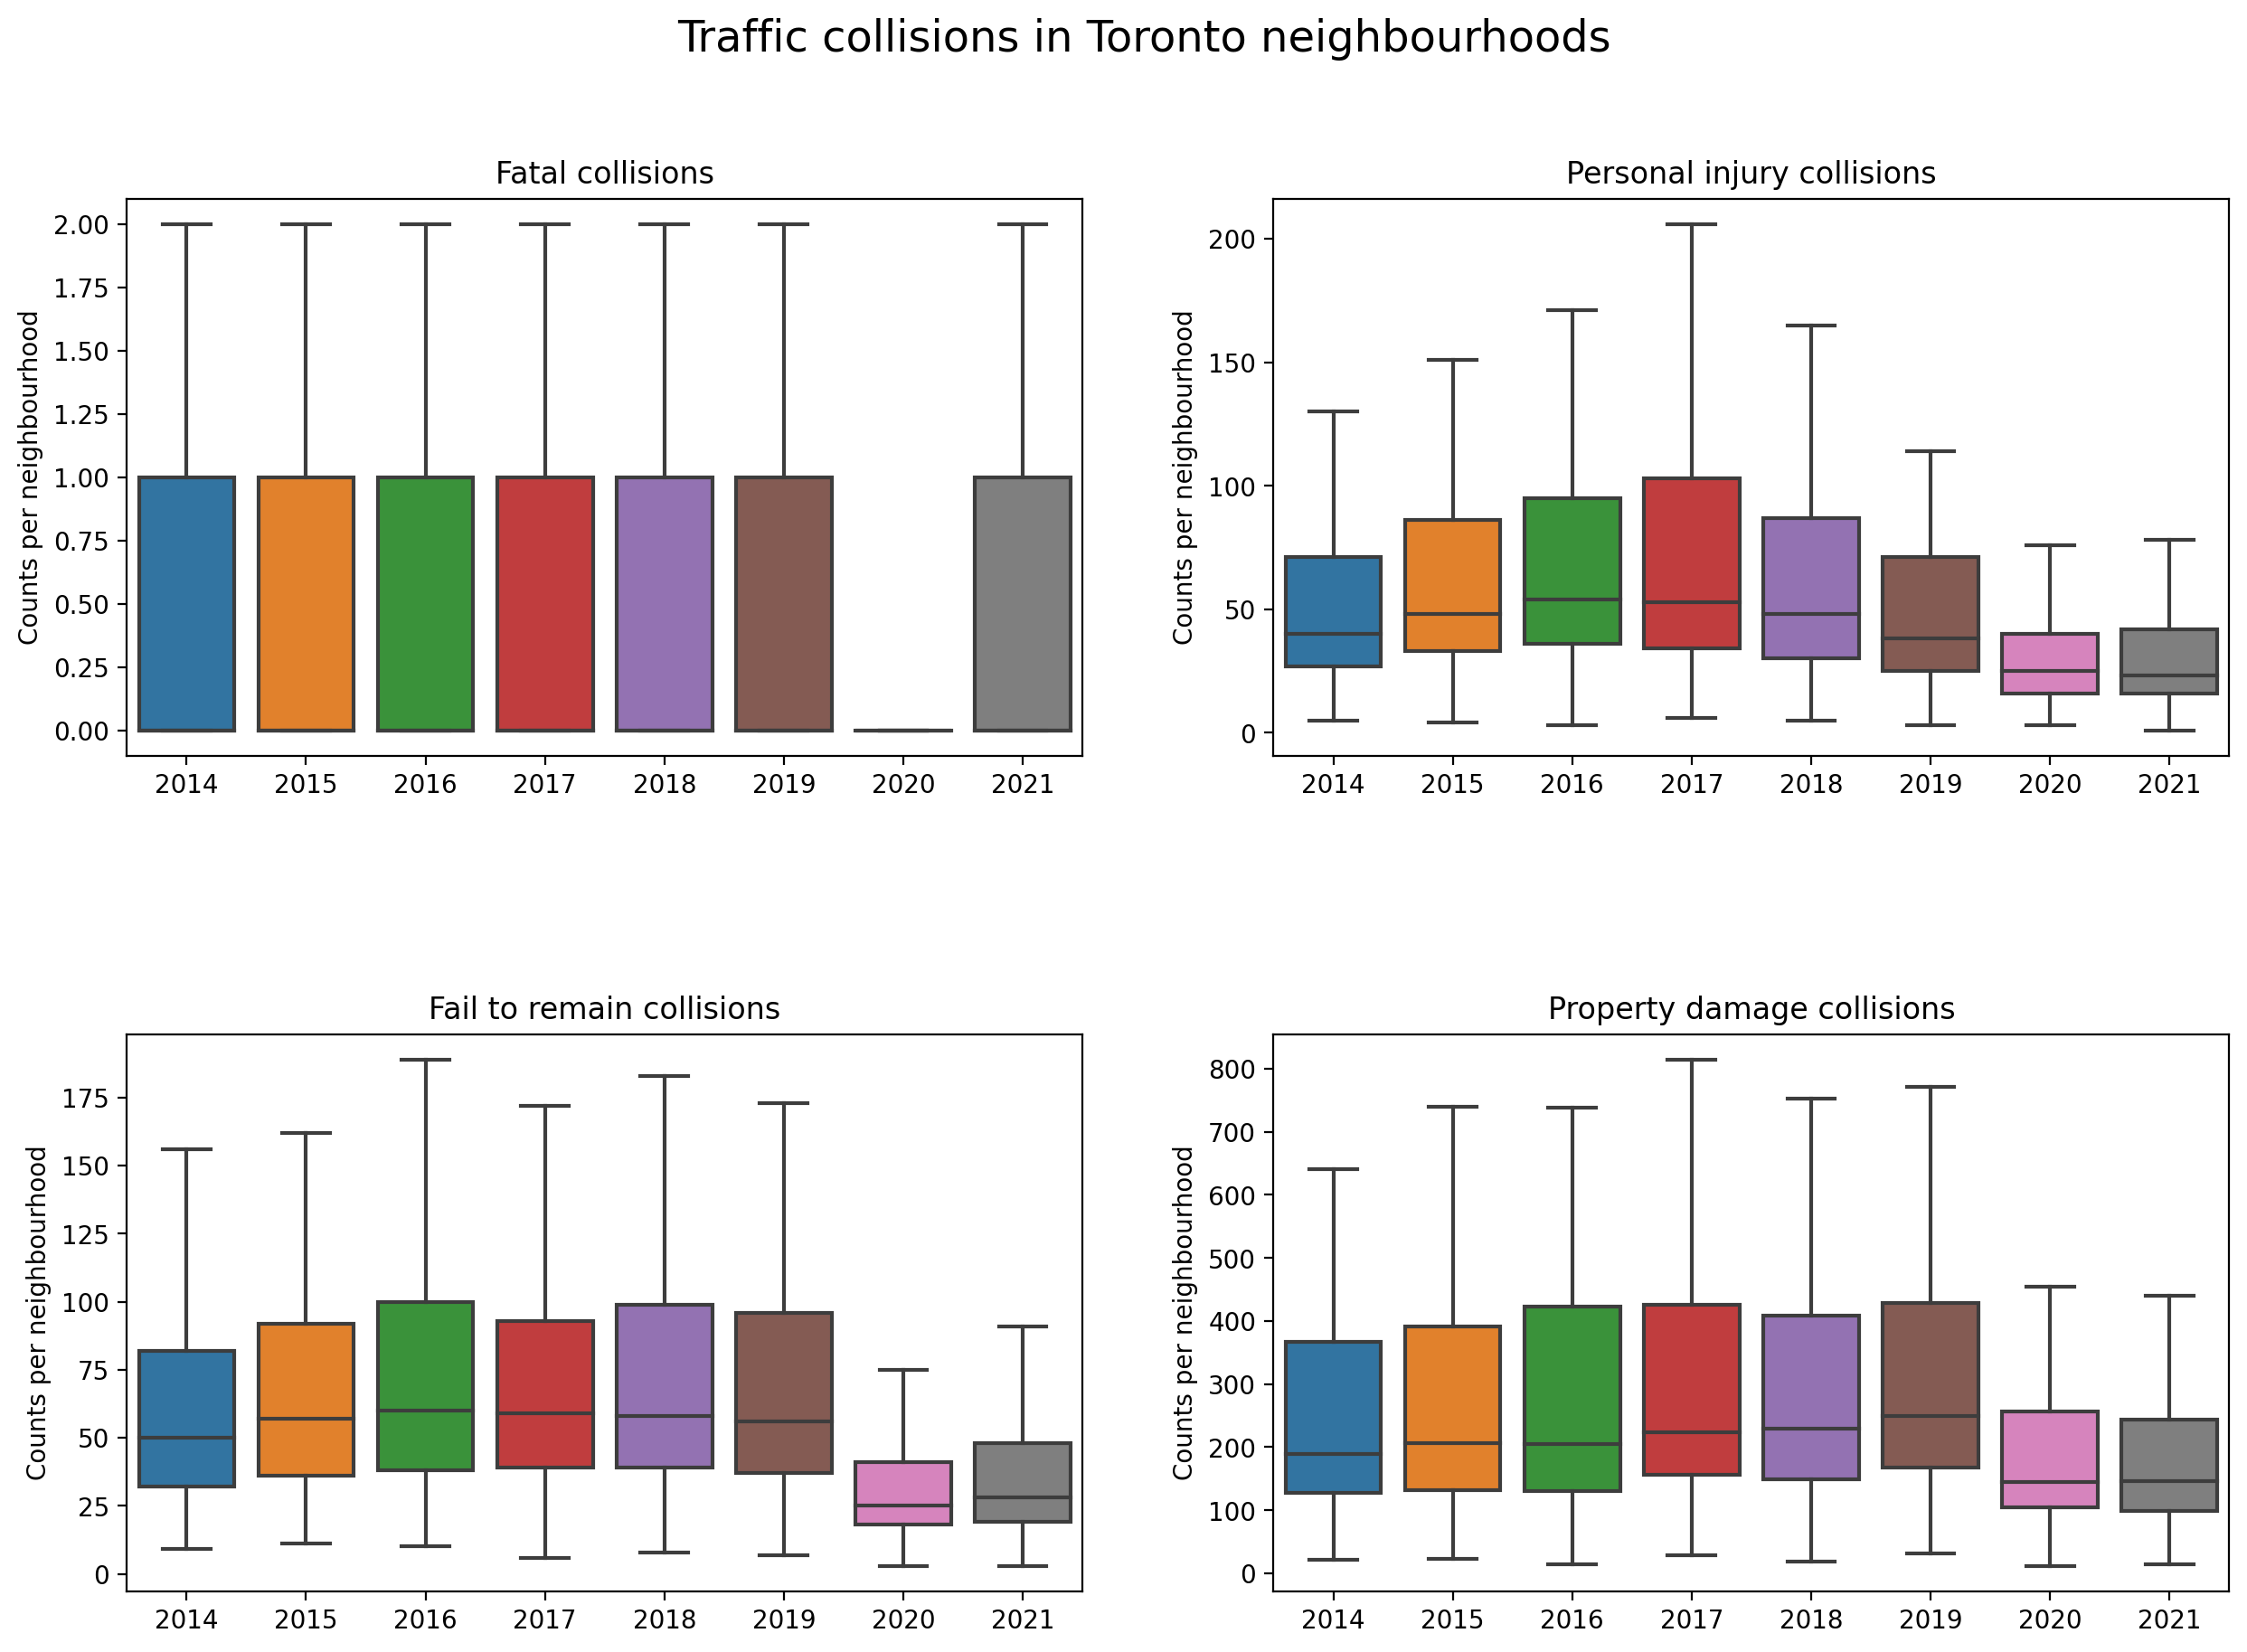

In [13]:
vars = ['fatal_collisions', 'injury_collisions', 'ftr_collisions', 'pd_collisions']
titles = ['Fatal collisions',
          'Personal injury collisions', 
          'Fail to remain collisions', 
          'Property damage collisions']
fig, axes = plt.subplots(int(math.ceil(len(vars)/2)),2)
plt.subplots_adjust(hspace=0.5)
for var, title, ax in zip(vars, titles, axes.flatten()):    
    sns.boxplot(data = collision_point.groupby(['neighbourhood', 'occurrence_year']).agg({var: 'sum'}).reset_index(), 
                x = 'occurrence_year',
                y = var,
                showfliers = False,
                ax = ax)
    ax.set_ylabel('Counts per neighbourhood')
    ax.set_xlabel('')
    ax.set_title(f"{title}")

fig.suptitle('Traffic collisions in Toronto neighbourhoods', size='xx-large')

# Neighbourhood collision rate and density

In [14]:
collision_by_quarter = pd.read_csv('../data/processed/neighbourhoods_collision.csv')
collision_by_quarter.hood_id = collision_by_quarter.hood_id.astype(str)
collision_by_quarter

neighbourhood hood_id  occurrence_year  occurrence_quarter  \
0      West Humber-Clairville       1             2014                   1   
1      West Humber-Clairville       1             2014                   2   
2      West Humber-Clairville       1             2014                   3   
3      West Humber-Clairville       1             2014                   4   
4      West Humber-Clairville       1             2014                   1   
...                       ...     ...              ...                 ...   
67195     Mount Pleasant East      99             2021                   4   
67196     Mount Pleasant East      99             2021                   1   
67197     Mount Pleasant East      99             2021                   2   
67198     Mount Pleasant East      99             2021                   3   
67199     Mount Pleasant East      99             2021                   4   

            area  population    collision_type     type       value  
0      30.145103       34745         collision    count  353.000000  
1      30.145103       34745         collision    count  303.000000  
2      30.145103       34745         collision    count  322.000000  
3      30.145103       34745         collision    count  312.000000  
4      30.145103       34745  fatal_collisions    count    0.000000  
...          ...         ...               ...      ...         ...  
67195   3.088880       18261    ftr_collisions  density    2.913678  
67196   3.088880       18261     pd_collisions  density   15.539613  
67197   3.088880       18261     pd_collisions  density   11.654710  
67198   3.088880       18261     pd_collisions  density   17.482065  
67199   3.088880       18261     pd_collisions  density   26.870582  

[67200 rows x 9 columns]

In [15]:
collision_by_year = collision_by_quarter.groupby(['hood_id', 'occurrence_year', 'collision_type', 'type']).value.sum().reset_index()
collision_by_year

hood_id  occurrence_year     collision_type     type        value
0           1             2014          collision    count  1290.000000
1           1             2014          collision  density    42.793021
2           1             2014          collision     rate  3712.764427
3           1             2014   fatal_collisions    count     3.000000
4           1             2014   fatal_collisions  density     0.099519
...       ...              ...                ...      ...          ...
16795      99             2021  injury_collisions  density     9.388516
16796      99             2021  injury_collisions     rate   158.808389
16797      99             2021      pd_collisions    count   221.000000
16798      99             2021      pd_collisions  density    71.546970
16799      99             2021      pd_collisions     rate  1210.229451

[16800 rows x 5 columns]

In [16]:
neighbourhoods = gpd.read_file('../data/processed/neighbourhoods.geojson')

In [17]:
neighbourhoods_collision = neighbourhoods[['hood_id', 'geometry']].drop_duplicates(subset = 'hood_id').merge(collision_by_year, on='hood_id', how='left')
neighbourhoods_collision

hood_id                                           geometry  \
0           1  POLYGON ((-79.55235 43.70947, -79.55237 43.709...   
1           1  POLYGON ((-79.55235 43.70947, -79.55237 43.709...   
2           1  POLYGON ((-79.55235 43.70947, -79.55237 43.709...   
3           1  POLYGON ((-79.55235 43.70947, -79.55237 43.709...   
4           1  POLYGON ((-79.55235 43.70947, -79.55237 43.709...   
...       ...                                                ...   
16795      99  POLYGON ((-79.37747 43.71309, -79.37737 43.712...   
16796      99  POLYGON ((-79.37747 43.71309, -79.37737 43.712...   
16797      99  POLYGON ((-79.37747 43.71309, -79.37737 43.712...   
16798      99  POLYGON ((-79.37747 43.71309, -79.37737 43.712...   
16799      99  POLYGON ((-79.37747 43.71309, -79.37737 43.712...   

       occurrence_year     collision_type     type        value  
0                 2014          collision    count  1290.000000  
1                 2014          collision  density    42.793021  
2                 2014          collision     rate  3712.764427  
3                 2014   fatal_collisions    count     3.000000  
4                 2014   fatal_collisions  density     0.099519  
...                ...                ...      ...          ...  
16795             2021  injury_collisions  density     9.388516  
16796             2021  injury_collisions     rate   158.808389  
16797             2021      pd_collisions    count   221.000000  
16798             2021      pd_collisions  density    71.546970  
16799             2021      pd_collisions     rate  1210.229451  

[16800 rows x 6 columns]

In [18]:
collision_type = neighbourhoods_collision.collision_type.unique()
collision_type

array(['collision', 'fatal_collisions', 'ftr_collisions',
       'injury_collisions', 'pd_collisions'], dtype=object)

In [19]:
# set custom order for display
custom_collision_order = ['collision','fatal_collisions', 'injury_collisions','ftr_collisions','pd_collisions']
collision_years = sorted(neighbourhoods_collision.occurrence_year.unique())

In [20]:
def plot_collision(var, title):
    fig, axes = plt.subplots(len(collision_years), len(custom_collision_order))

    for j in range(axes.shape[1]):
        # fix the range for each type of collision so we can compare across years
        vmin, vmax = neighbourhoods_collision[(neighbourhoods_collision['collision_type'] == custom_collision_order[j]) &
                                              (neighbourhoods_collision['type'] == var)].value.agg(['min', 'max'])
        norm = TwoSlopeNorm(
            vmin=vmin, vcenter=np.mean([vmin, vmax]), vmax=vmax)
        print(custom_collision_order[j])
        for i in range(axes.shape[0]):
            try:
                neighbourhoods_collision[(neighbourhoods_collision['collision_type'] == custom_collision_order[j]) &
                                         (neighbourhoods_collision['occurrence_year'] == collision_years[i]) &
                                         (neighbourhoods_collision['type'] == var)].\
                    plot(column='value',
                         cmap='viridis',
                         norm=norm,
                         ax=axes[i, j])
            except:
                print(
                    f"problem with {custom_collision_order[j]} and {collision_years[i]}")
                break

            axes[i, j].xaxis.set_visible(False)
            axes[i, j].set_yticks([])
            if i == 0:
                axes[i,j].set_title(custom_collision_order[j])
            if j == 0:
                axes[i,j].set_ylabel(collision_years[i], rotation=90, size='large')

    fig.suptitle(title, size='xx-large')


## plot map

collision
fatal_collisions
injury_collisions
ftr_collisions
pd_collisions


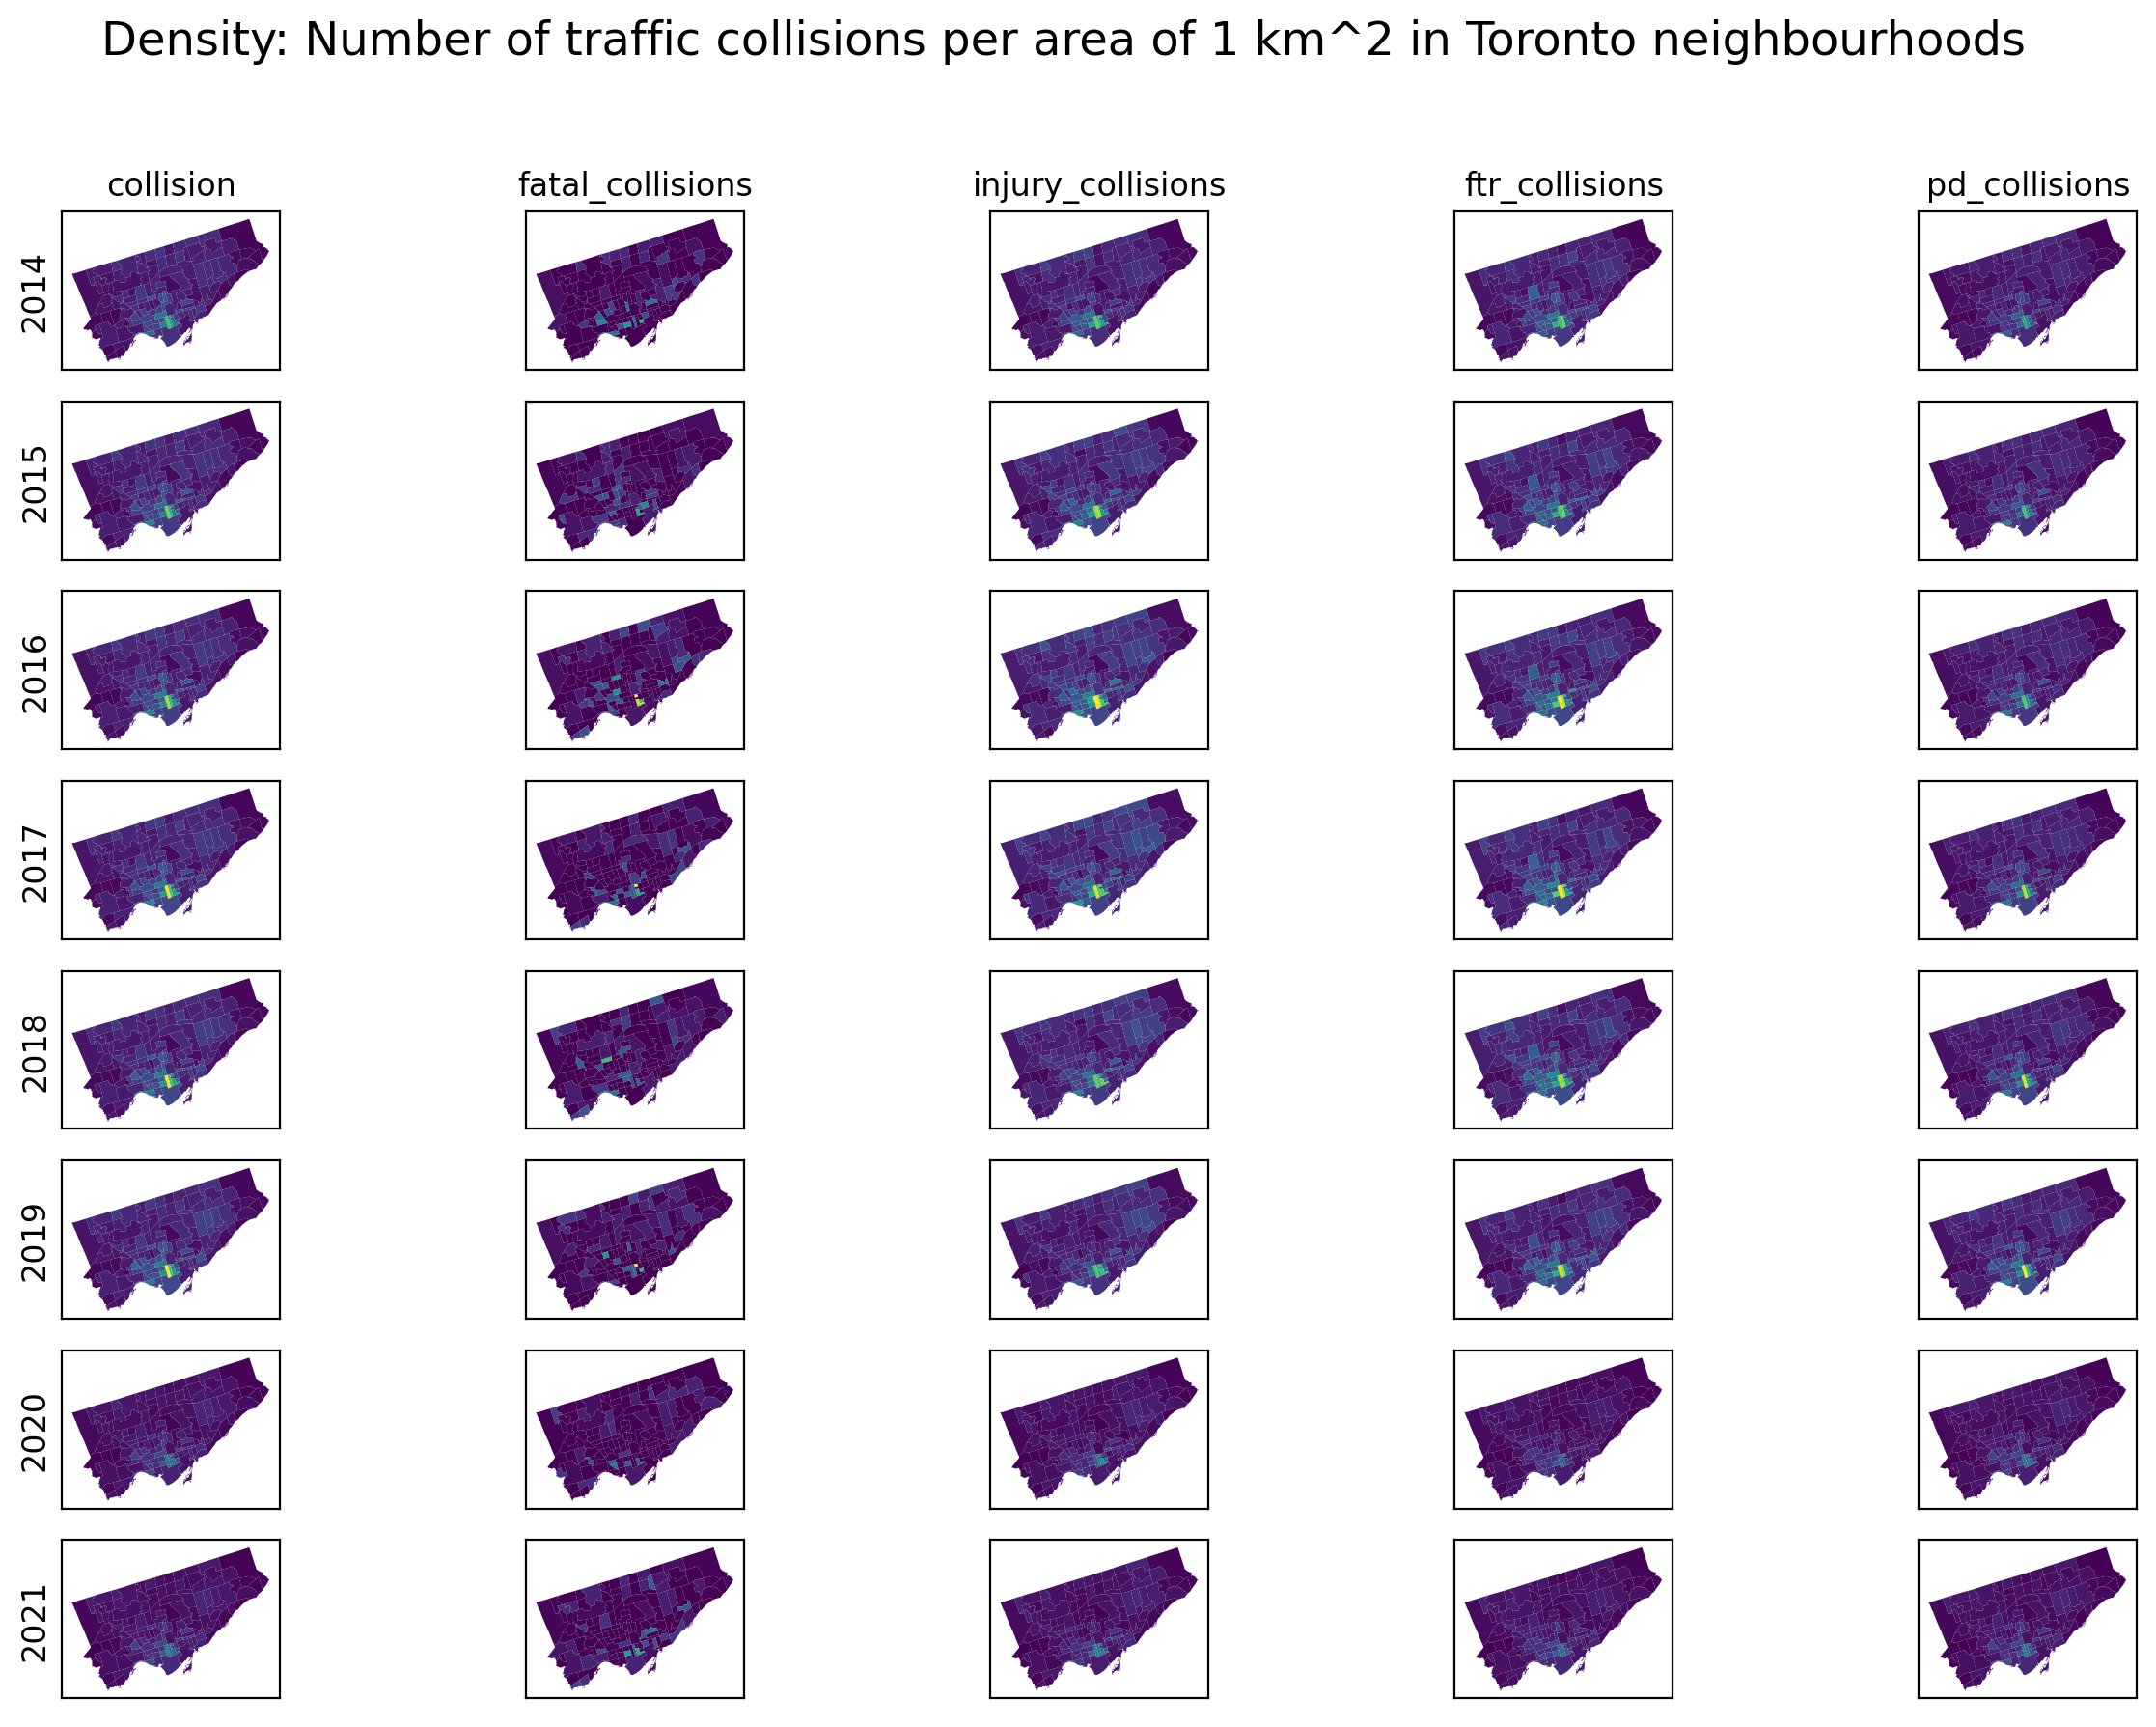

In [21]:
plot_collision('density', 'Density: Number of traffic collisions per area of 1 km^2 in Toronto neighbourhoods')

collision
fatal_collisions
injury_collisions
ftr_collisions
pd_collisions


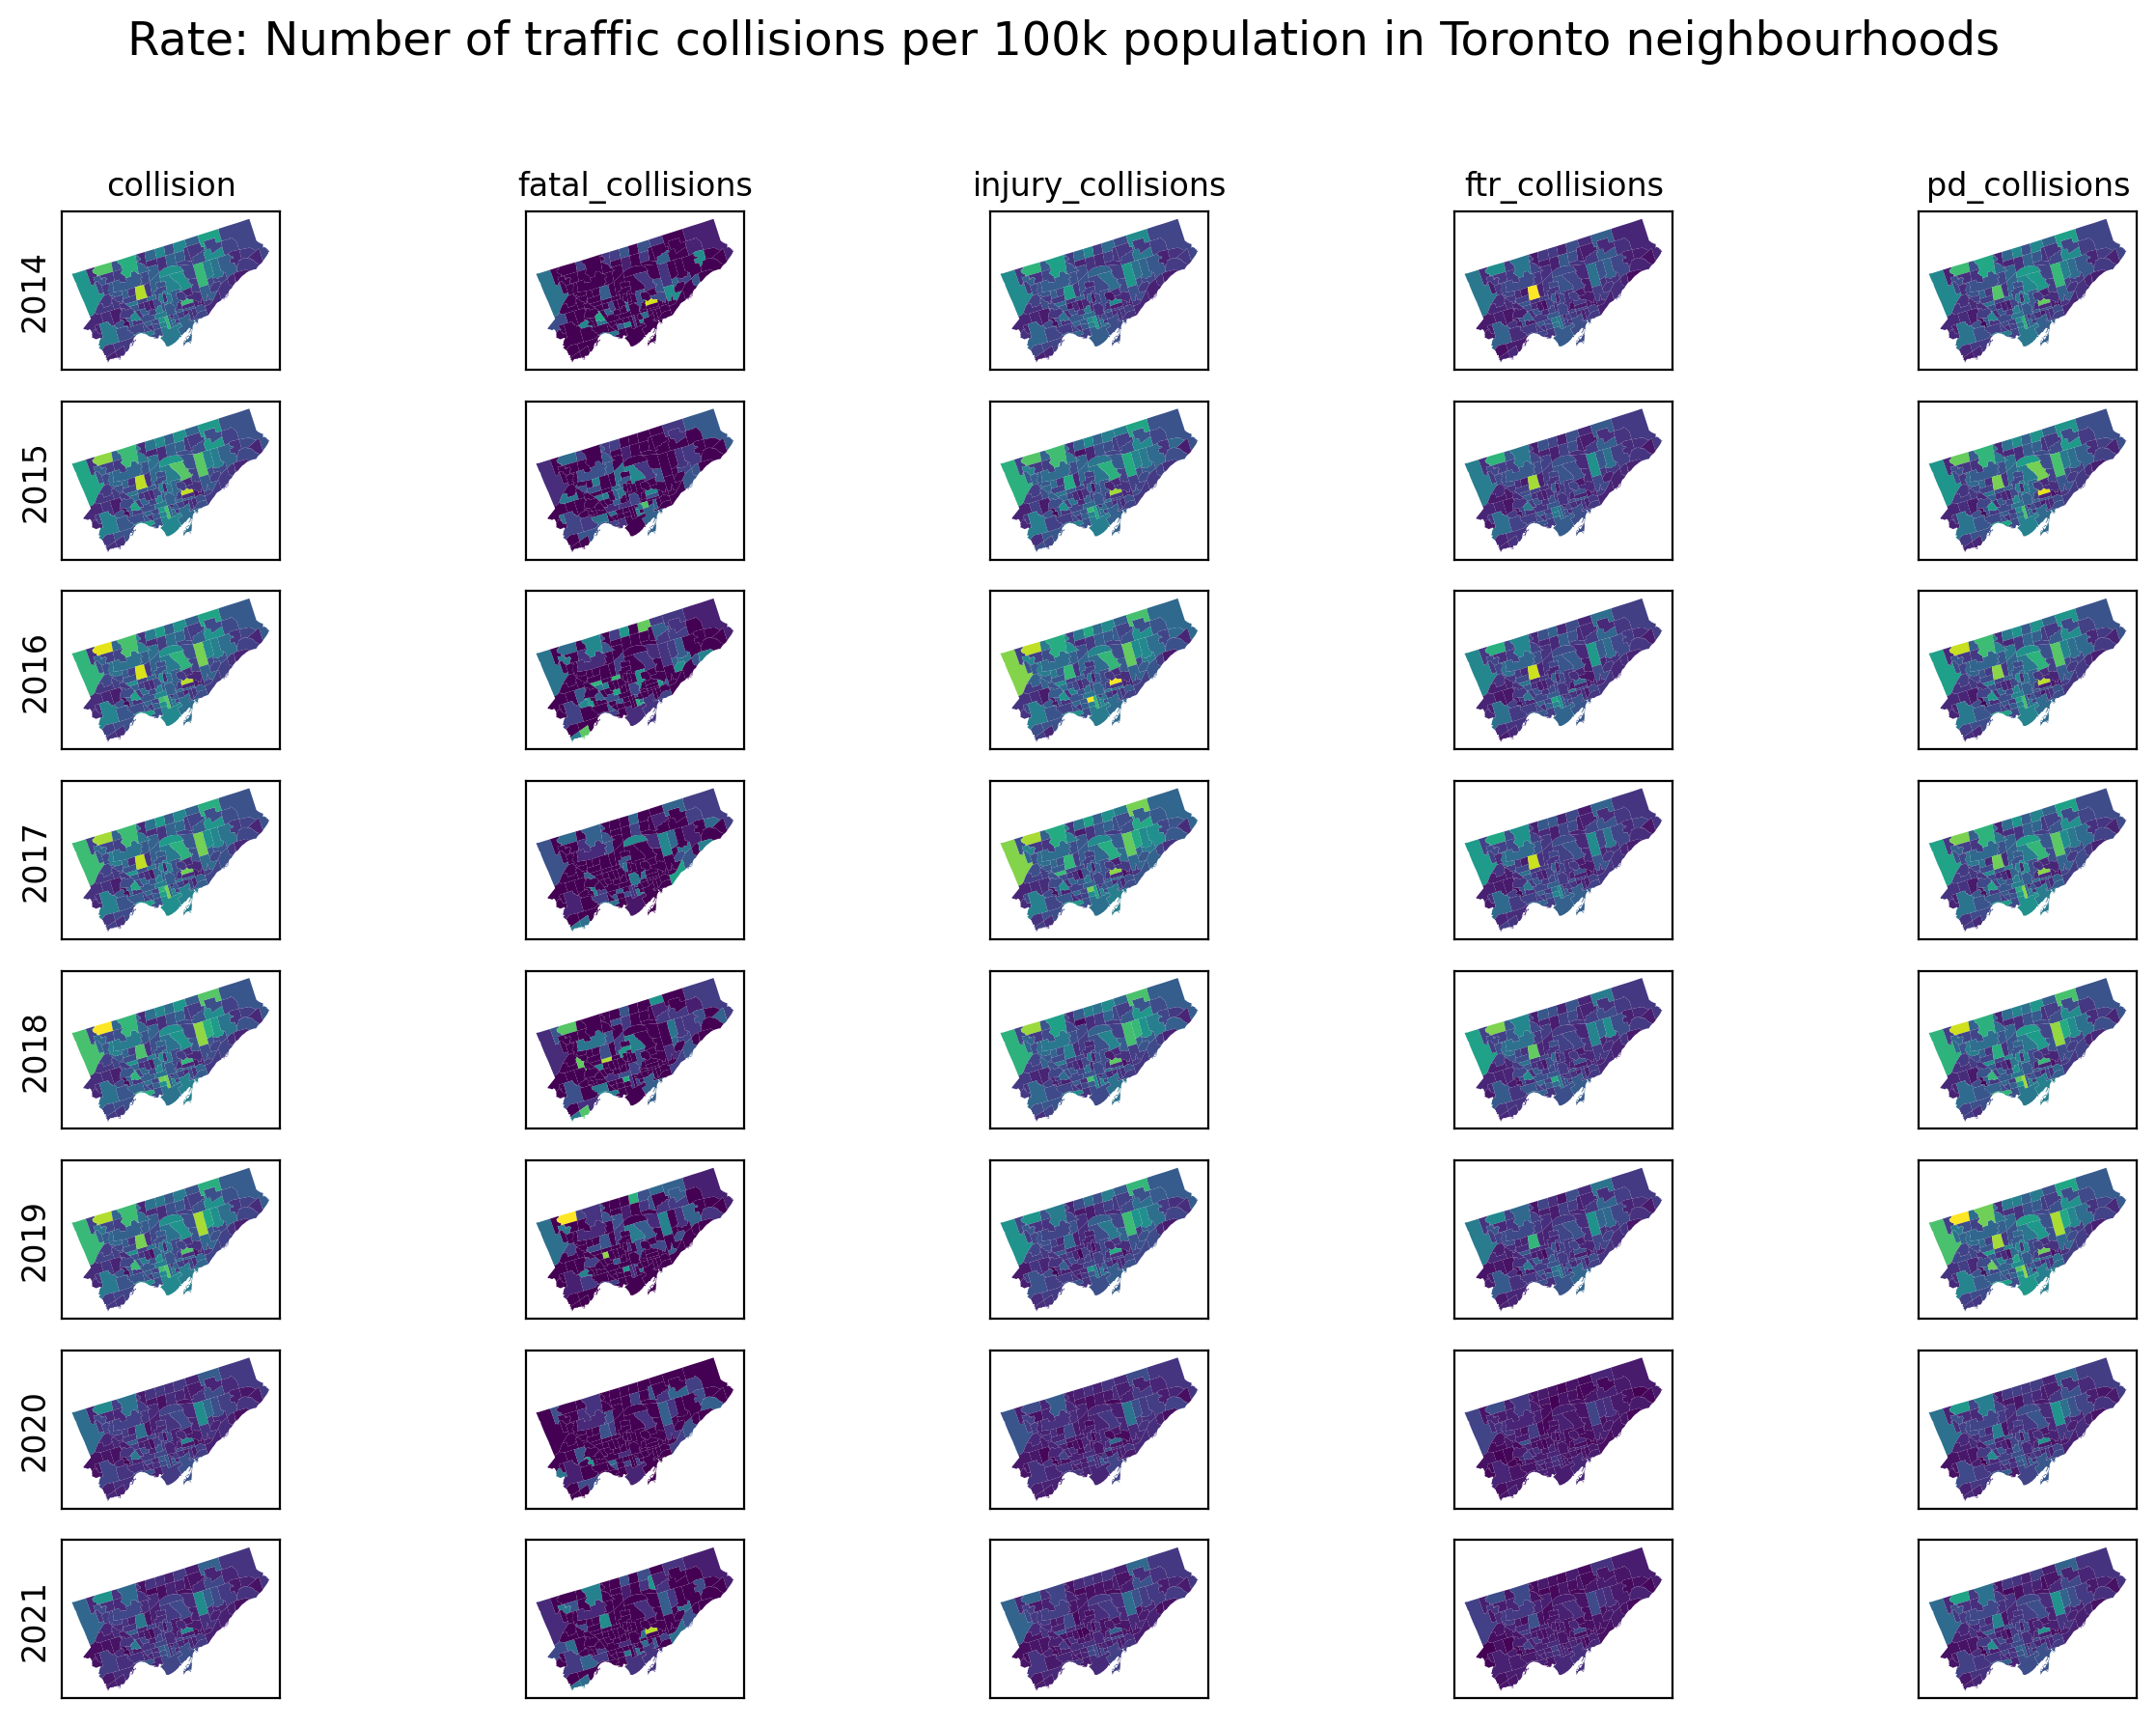

In [22]:
plot_collision('rate', 'Rate: Number of traffic collisions per 100k population in Toronto neighbourhoods')

collision
fatal_collisions
injury_collisions
ftr_collisions
pd_collisions


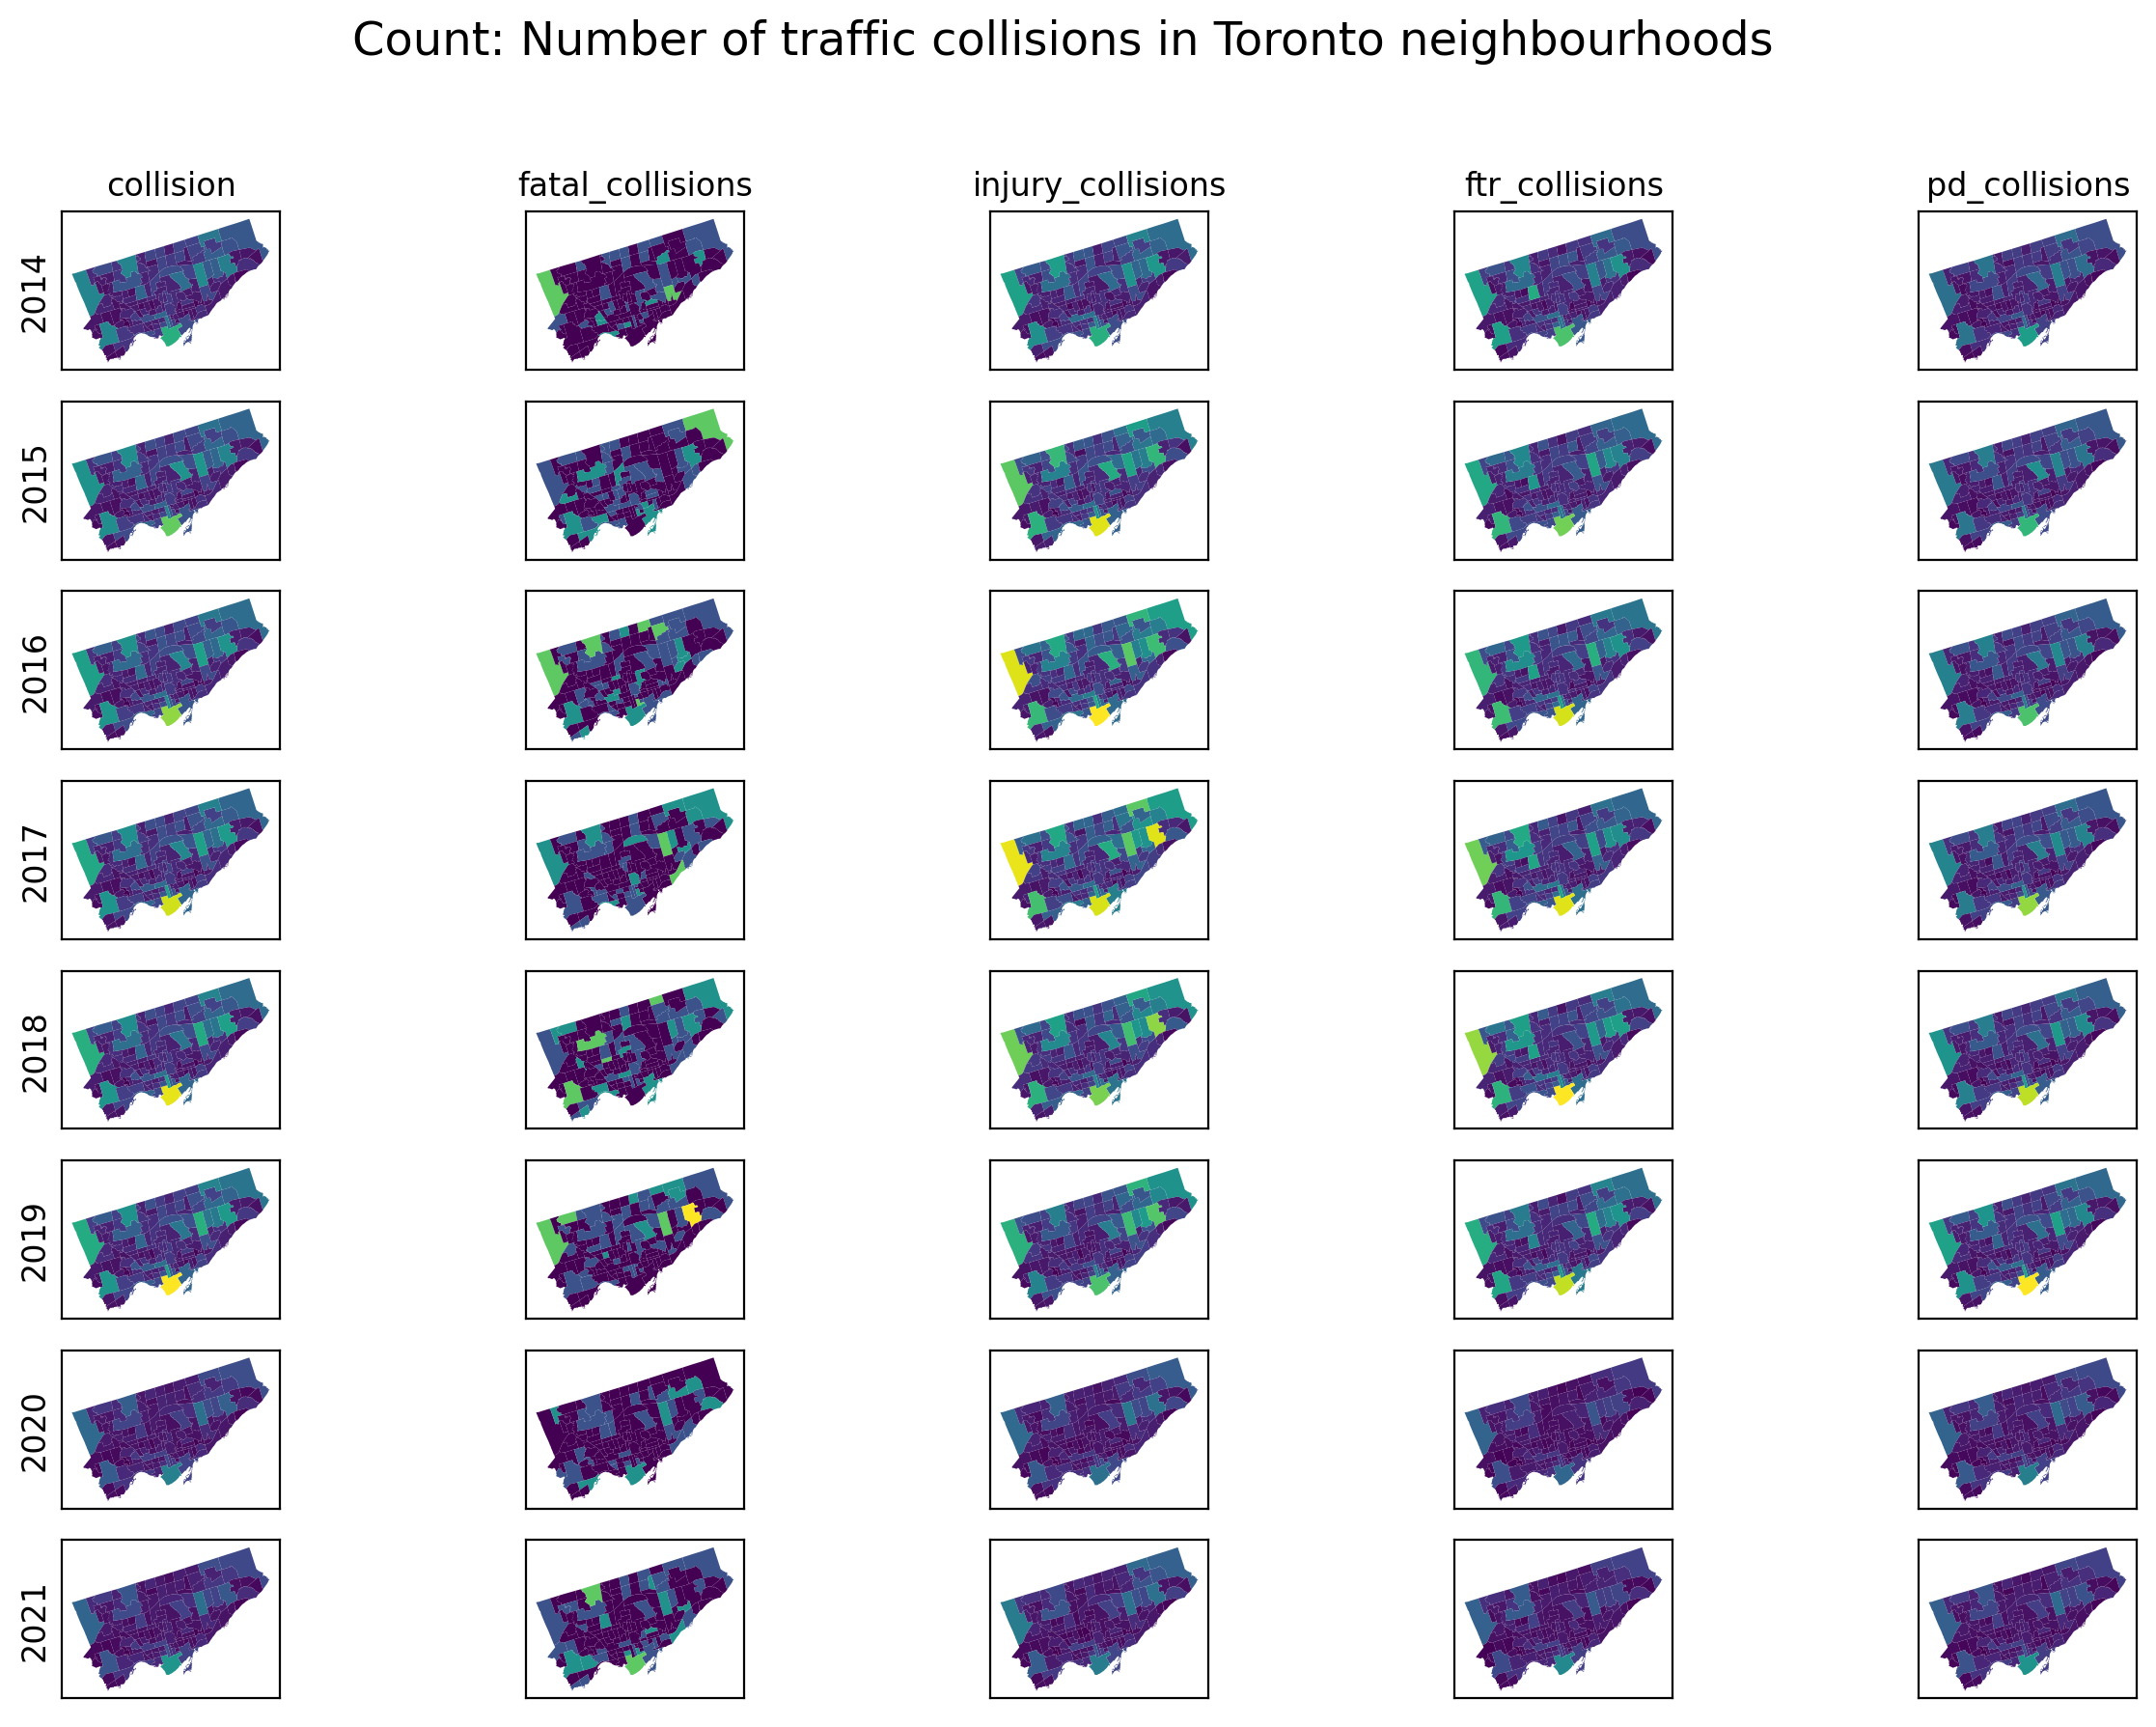

In [23]:
plot_collision('count', 'Count: Number of traffic collisions in Toronto neighbourhoods')

In [ ]:
# plotly version
# crime_allrate = pd.wide_to_long(neighbourhoods_crime[['Neighbourhood', 'hood_id', 'geometry'] + ['All_Rate' + str(year) for year in crime_years]],]], 
#                                   stubnames= "All_Rate", 
#                                   i=['Neighbourhood', 'hood_id'], 
#                                   j='year',
#                                   sep='').reset_index()

# crime_allrate.head()

# fig = px.choropleth(crime_allrate, 
#               geojson=crime_allrate.geometry,
#               locations=crime_allrate.index,
#               color = 'All_Rate',
#               animation_frame='year',
#               color_continuous_scale="Viridis",
#               hover_data=['Neighbourhood'])
# fig.update_geos(fitbounds="locations", visible=False)

Text(0.5, 257.537970073787, 'Longitude')

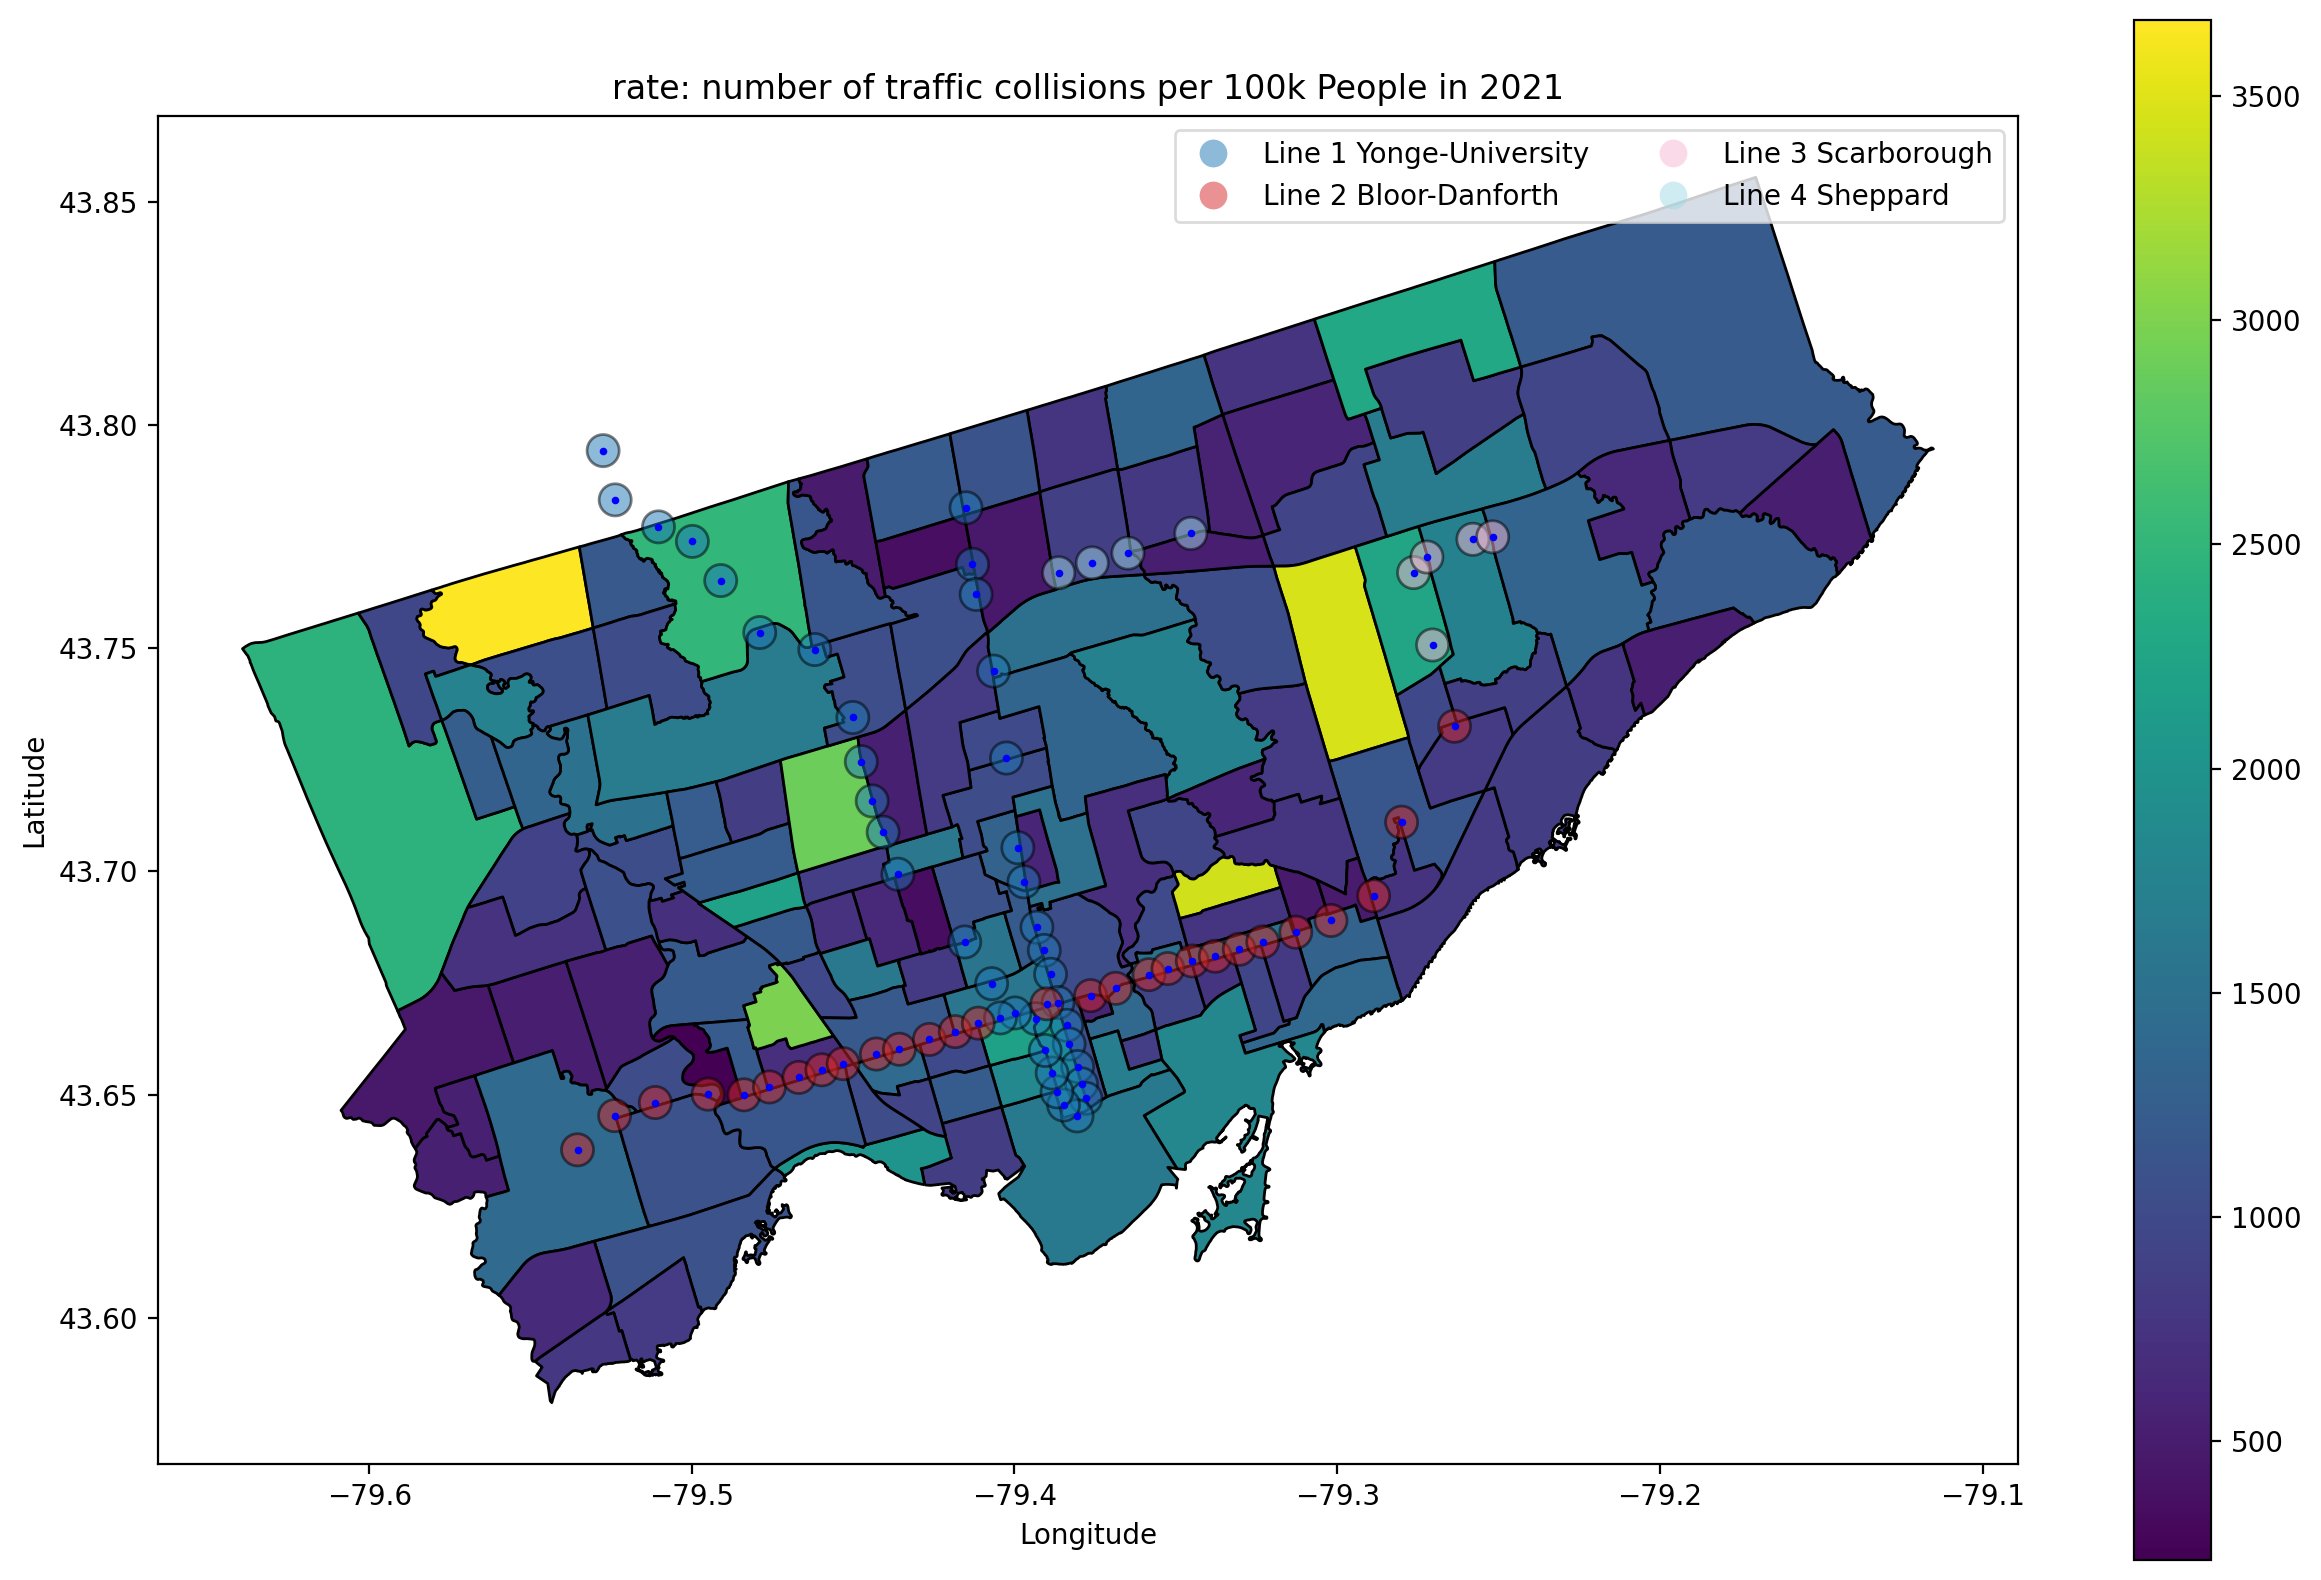

In [27]:
var = "rate"
collision_var = "collision"
year = neighbourhoods_collision['occurrence_year'].max()
ax = neighbourhoods_collision[(neighbourhoods_collision['collision_type'] == collision_var) & 
                          (neighbourhoods_collision['occurrence_year'] == year) & 
                          (neighbourhoods_collision['type'] == var)].\
                              plot(column = 'value', 
                                   edgecolor = 'black',
                                   cmap = 'viridis',
                                   # norm = norm,
                                   legend = True)

stations_area.plot(column = 'line', 
                edgecolor = 'black', 
                alpha = 0.5,
                cmap = 'tab20',
                legend = True,
                legend_kwds = {'loc': 'upper right', 
                                'ncol': 2,
                                'edgecolor': 'lightgrey'},
                ax = ax)
stations_point.plot(ax=ax, 
                    color = 'blue', 
                    markersize = 3)

ax.set_title(var + ": number of traffic collisions per 100k People in " + str(year))
ax.set_ylabel("Latitude")
ax.set_xlabel("Longitude")

# Traffic collision around subway stations

In [28]:
collision_point['geometry'] = collision_point.apply(lambda x: shapely.geometry.Point(x['longitude'], x['latitude']), axis=1)
collision_point = gpd.GeoDataFrame(collision_point, crs='epsg:' + str(epsg_3d), geometry='geometry')

c:\Users\willi\miniconda3\envs\police\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [29]:
custom_collision_order

['collision',
 'fatal_collisions',
 'injury_collisions',
 'ftr_collisions',
 'pd_collisions']

In [30]:
year = neighbourhoods_collision['occurrence_year'].max()
collision_around_stations = gpd.sjoin(collision_point.loc[(collision_point['occurrence_year'] == year), ['occurrence_unique_id', 'hood_id', 'geometry']], 
                                  stations_area[['station', 'geometry']],
                                  predicate='intersects')
collision_around_stations

occurrence_unique_id hood_id                    geometry  index_right  \
415716       GO-20211140647      50  POINT (-79.41596 43.78164)            0   
417257       GO-20211339711      51  POINT (-79.41505 43.77789)            0   
417694       GO-20211543145      36  POINT (-79.41596 43.78164)            0   
417809       GO-20211419581      51  POINT (-79.41554 43.77977)            0   
418087       GO-20211569148      51  POINT (-79.41554 43.77977)            0   
...                     ...     ...                         ...          ...   
443770       GO-20218026692      31  POINT (-79.44377 43.70900)           27   
444133       GO-20218027441      31  POINT (-79.44377 43.70900)           27   
445281       GO-20218026774      31  POINT (-79.44377 43.70900)           27   
447552       GO-20218029779      31  POINT (-79.44377 43.70900)           27   
449526       GO-20218032921      31  POINT (-79.44413 43.70987)           27   

          station  
415716      finch  
417257      finch  
417694      finch  
417809      finch  
418087      finch  
...           ...  
443770  glencairn  
444133  glencairn  
445281  glencairn  
447552  glencairn  
449526  glencairn  

[6517 rows x 5 columns]

In [31]:
station_rank = collision_around_stations.groupby(['station']).size().sort_values(ascending=False).reset_index(name = 'collision_count')
station_rank

station  collision_count
0             queen              260
1              king              244
2       bloor yonge              234
3             union              222
4         st andrew              215
..              ...              ...
68   downsview park               17
69        ellesmere               12
70         old mill                9
71  york university                7
72  pioneer village                3

[73 rows x 2 columns]

Text(0.5, 1.0, 'Distribution of collision around stations seems in line with collision density across neighbourhoods')

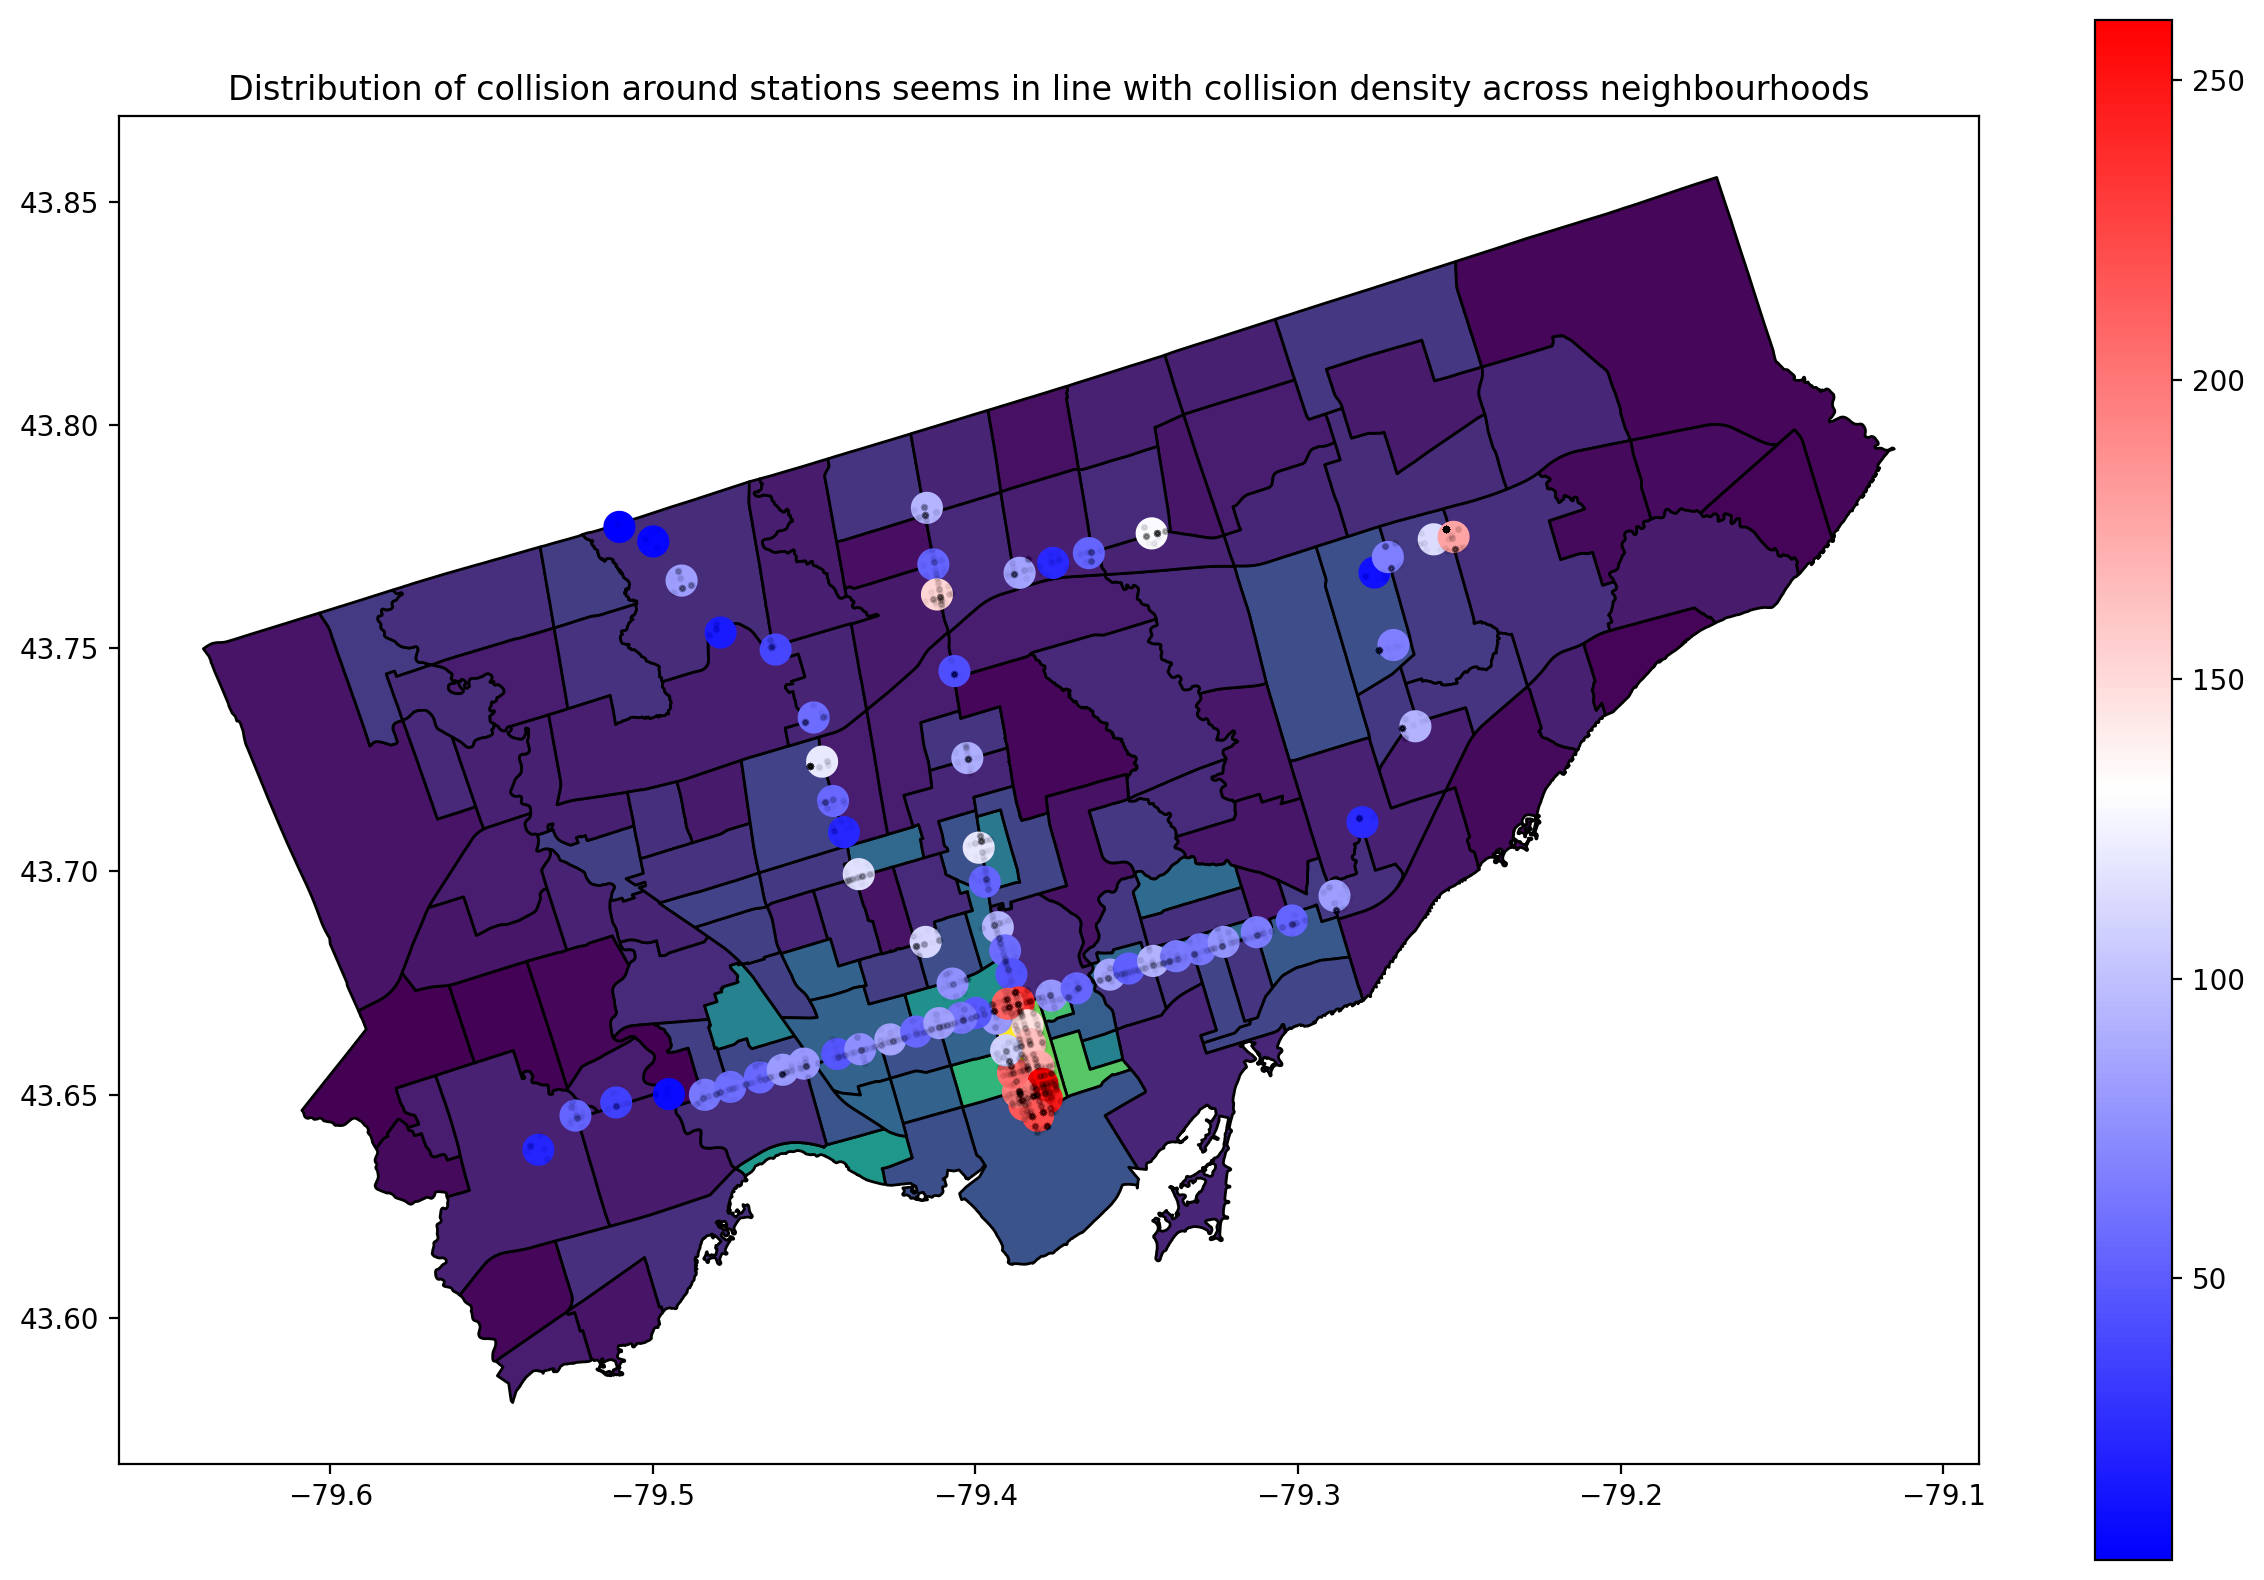

In [32]:
collision_var = "collision"
year = neighbourhoods_collision['occurrence_year'].max()
var = 'density'
ax = neighbourhoods_collision[(neighbourhoods_collision['collision_type'] == collision_var) & 
                          (neighbourhoods_collision['occurrence_year'] == year) & 
                          (neighbourhoods_collision['type'] == var)].\
                              plot(column = 'value', 
                                   edgecolor = 'black',
                                   cmap = 'viridis',
                                   )
stations_area.merge(station_rank, on='station', how='left').plot(
    column = 'collision_count', 
    ax=ax, cmap = 'bwr', markersize = 3, legend = True)
collision_around_stations.plot(ax=ax, color = 'black', markersize = 3, alpha = 0.01)
ax.set_title("Distribution of collision around stations seems in line with collision density across neighbourhoods")